# DataJoint Elements for Volumetric Fluorescent Microscopy

#### Open-source data pipeline for processing and analyzing volumetric imaging datasets.

Welcome to the tutorial for the DataJoint Element for volumetric (z-stack) imaging data. This tutorial aims to provide a comprehensive understanding of the open-source data pipeline created using `element-zstack`.

This package is designed to seamlessly process, ingest, and track volumetric imaging data, along with its associated parameters such as those used for image segmentation with [cellpose](https://github.com/MouseLand/cellpose), and uploading the volume and segmentation data to [BossDB](https://bossdb.org) and visualization with [neuroglancer](https://github.com/google/neuroglancer). By the end of this tutorial, you will have a clear grasp on setting up and integrating `element-zstack` into your specific research projects and lab.

![flowchart](../images/flowchart.svg)

### Prerequisites

Please see the [datajoint tutorials GitHub
repository](https://github.com/datajoint/datajoint-tutorials/tree/main) before
proceeding.

A basic understanding of the following DataJoint concepts will be beneficial to your
understanding of this tutorial: 
1. The `Imported` and `Computed` tables types in `datajoint-python`.
2. The functionality of the `.populate()` method. 

#### **Tutorial Overview**

+ Setup
+ *Activate* the DataJoint pipeline.
+ *Insert* subject, session, and scan metadata.
+ *Populate* volume metadata from image files.
+ Run the volume segmentation task.
+ Upload data to BossDB.
+ Visualize the results in Neuroglancer.

### **Setup**

This tutorial examines volumetric imaging data acquired with `ScanImage` and processed via
`cellpose`. The goal is to store, track, and manage sessions of z-stack imaging data,
including all outputs of image segmentations. 

The results of this Element can be combined with **other modalities** to create
a complete, customizable data pipeline for your specific lab or study. For instance, you
can combine `element-zstack` with `element-array-ephys` and
`element-deeplabcut` to characterize the neural activity along with markless
pose-estimation during behavior.

### **Additional Information**

While this tutorial contains the sample code to upload volumes to `BossDB`, this feature is **not supported** in the Codespaces tutorial environment. To upload your data to BossDB, and use the neuroglancer visualization tool, please follow the steps at the end of this notebook: 




In this notebook, we will explain the following concepts as they relate to this workflow:
- What is an Element versus a Workflow?
- Plot the workflow with `dj.Diagram`
- Insert data into tables
- Query table contents
- Fetch table contents
- Run the workflow for your experiments

For detailed documentation and tutorials on general DwataJoint principles that support collaboration, automation, reproducibility, and visualizations:

- [DataJoint Interactive Tutorials](https://github.com/datajoint/datajoint-tutorials) - Fundamentals including table tiers, query operations, fetch operations, automated computations with the `make` function, etc.

- [DataJoint Core - Documentation](https://datajoint.com/docs/core/) - Relational data model principles

- [DataJoint API for Python - Documentation](https://datajoint.com/docs/core/datajoint-python/)

- [DataJoint Element for Volumetric Calcium Imaging - Documentation](https://datajoint.com/docs/elements/element-zstack/)

Let's start by importing the packages necessary to run the notebook.

In [2]:
import datetime
import datajoint as dj

If the tutorial is run in Codespaces, a private, local database server is created and
made available for you. This is where we will insert and store our processed results.
let's connect to the database server.

In [3]:
dj.conn()

[2024-04-03 03:44:05,175][INFO]: Connecting root@fakeservices.datajoint.io:3306
[2024-04-03 03:44:05,182][INFO]: Connected root@fakeservices.datajoint.io:3306


DataJoint connection (connected) root@fakeservices.datajoint.io:3306

### **Activate the DataJoint Pipeline**

This tutorial activates the `volume.py` and `bossdb.py` modules from `element-zstack`, along
with upstream dependencies from `element-animal` and `element-session`. Please refer to the
[`tutorial_pipeline.py`](./tutorial_pipeline.py) for the source code.

In [4]:
from tutorial_pipeline import (
    lab,
    subject,
    session,
    scan,
    volume,
    bossdb,
)

[2024-04-03 03:44:15,821][WARNING]: lab.Project and related tables will be removed in a future version of Element Lab. Please use the project schema.


We can represent the tables in the `volume` and `bossdb` schemas as well as some of the
upstream dependencies to `session` and `subject` schemas as a diagram.

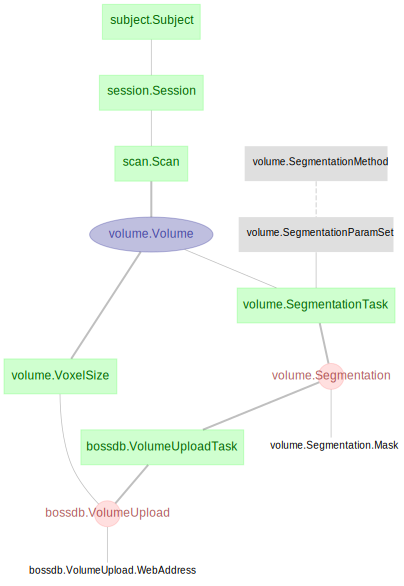

In [5]:
(
    dj.Diagram(subject.Subject)
    + dj.Diagram(session.Session)
    + dj.Diagram(scan.Scan)
    + dj.Diagram(volume)
    + dj.Diagram(bossdb)
)

As evident from the diagram, this data pipeline encompasses tables associated with
scan and volume metadata, results of volume segmentation, and upload and visualization of results. A few tables, such as `subject.Subject` or `session.Session`,
while important for a complete pipeline, fall outside the scope of the `element-zstack`
tutorial, and will therefore, not be explored extensively here. The primary focus of
this tutorial will be on the `volume` schema.

### **Insert subject, session, and probe metadata**

Let's start with the first table in the schema diagram (i.e. `subject.Subject` table).

To know what data to insert into the table, we can view its dependencies and attributes using the `.describe()` and `.heading` methods.

In [ ]:
subject.Subject()

In [ ]:
print(subject.Subject.describe())

In [ ]:
subject.Subject.heading

The cells above show all attributes of the `subject.Subject` table. We will insert data into this table below.

In [ ]:
subject.Subject.insert1(
    dict(
        subject="subject1",
        sex="M",
        subject_birth_date="2023-01-01",
        subject_description="Cellpose segmentation of volumetric data.",
    )
)
subject.Subject()

Let's repeat the steps above for the `Session` table and see how the output varies
between `.describe` and `.heading`.

In [ ]:
print(session.Session.describe())

In [ ]:
session.Session.heading

Notice that `describe`, displays the table's structure and highlights its dependencies, such as its reliance on the `Subject` table. These dependencies represent foreign key references, linking data across tables.

On the other hand, `heading` provides an exhaustive list of the table's attributes. This
list includes both the attributes declared in this table and any inherited from upstream
tables.

With this understanding, let's move on to insert a session associated with our subject.

We will insert into the `session.Session` table by passing a dictionary to the `insert1` method.

In [ ]:
session_key = dict(
    subject="subject1",
    session_id=0,
)
session.Session.insert1(
    dict(
        session_key,
        session_datetime=datetime.datetime.now(),
    ),
)
session.Session()

Every experimental session produces a set of data files. The purpose of the `SessionDirectory` table is to locate these files. It references a directory path relative to a root directory, defined in `dj.config["custom"]`. More information about `dj.config` is provided in the [documentation](https://datajoint.com/docs/elements/user-guide/).

In [ ]:
print(session.SessionDirectory.describe())

In [ ]:
session.SessionDirectory.heading

In [ ]:
session.SessionDirectory.insert1(
    dict(session_key, session_dir="subject1/session1"),
    skip_duplicates=True,
)
session.SessionDirectory()

As the Diagram indicates, the `scan.Scan` table needs to
contain data before the tables in the `volume` schema accept any data. Let's
start by inserting into `scan.Scan`, a table containing metadata about a calcium imaging
scan. 

In [ ]:
print(scan.Scan.describe())

The `Scan` table's attributes include the `Session` table **and** the `Device` table.
Let's insert into the `Device` table and then `Scan`.

In [ ]:
lab.Device.insert1(
    dict(
        device="Mesoscope1",
        modality="Calcium imaging",
        description="Example microscope",
    )
)

In [ ]:
scan.Scan.insert1(
    dict(
        session_key,
        scan_id=0,
        device="Mesoscope1",
        acq_software="ScanImage",
    ),
    skip_duplicates=True,
)
scan.Scan()

### **Populate volume metadata**

In the upcoming cells, the `.populate()` method will automatically extract and store the
volume metadata for each scan in the `volume.Volume` table.

In [ ]:
volume.Volume()

In [ ]:
volume.Volume.populate(session_key, display_progress=True)

Let's view the information was entered into this table.

In [ ]:
volume.Volume()

### **Run the Segmentation Task**

We're almost ready to perform volume segmentation with `cellpose`. An important step before
processing is managing the parameters which will be used in that step. To do so, we will
insert parameters required by cellpose into a DataJoint table
`SegmentationParamSet`. This table keeps track of all combinations of your image
processing parameters. You can choose which parameters are used during
processing in a later step.

Let's view the attributes and insert data into `volume.SegmentationParamSet`.

In [ ]:
volume.SegmentationParamSet.heading

In [ ]:
volume.SegmentationParamSet.insert_new_params(
    segmentation_method="cellpose",
    paramset_idx=1,
    params=dict(
        diameter=None,
        min_size=2,
        do_3d=False,
        anisotropy=0.5,
        model_type="nuclei",
        channels=[[0, 0]],
        z_axis=0,
        skip_duplicates=True,
    ),
)

DataJoint uses a `SegmentationTask` table to
manage which `Volume` and `SegmentationParamSet` should be used during processing. 

This table is important for defining several important aspects of
downstream processing. Let's view the attributes to get a better understanding. 

In [ ]:
print(volume.SegmentationTask.describe())

In [ ]:
volume.SegmentationTask.heading

The `SegmentationTask` table contains two important attributes: 
+ `paramset_idx` - Allows the user to choose the parameter set on which to run segmentation analysis.
+ `task_mode` - Can be set to `load` or `trigger`. When set to `load`, running the processing step initiates a search for existing output files of image segmentation. When set to `trigger`, the segmentation step will run cellpose on the raw data.

In [ ]:
volume.SegmentationTask.insert1(
    dict(
        **session_key,
        scan_id=0,
        paramset_idx=1,
        task_mode="load",
        processing_output_dir="subject1/session1/segmentation",
    ),
)

Let's call populate on the `Segmentation` table, which checks for cellpose results since `task_mode=load`. Please note, this step may take a few minutes to run. 

In [ ]:
volume.Segmentation.populate(session_key, display_progress=True)

In [ ]:
volume.Segmentation()

In [ ]:
volume.Segmentation.Mask()

### **Upload to BossDB**

**Not supported in Codespaces**: Please scroll to the bottom of this notebook for instructions on how to upload data to BossDB.

Volumetric data uploaded to BossDB requires information about voxel size. The
DataJoint table `volume.VoxelSize` can be used to insert this information for a
given dataset.

In [ ]:
volume.VoxelSize.heading

In [ ]:
volume.VoxelSize.insert1(
    dict(**session_key, scan_id=0, width=0.001, height=0.001, depth=0.001)
)

Let's define an `upload_key` to automatically upload the volume to BossDB via the
`bossdb` schema. The `upload_key` combines information about the current scan from
`scan.Scan` and the `paramset_idx` from `SegmentationParamSet`.

In [ ]:
upload_key = dict(**session_key, scan_id=0, paramset_idx=1)

The first table in this schema is `VolumeUploadTask`. Let's define the upload task by naming the collection, experiment,
and channel where the data should be uploaded.

In [ ]:
print(bossdb.VolumeUploadTask.describe())

In [ ]:
bossdb.VolumeUploadTask.heading

In [ ]:
collection = "dataJointTestUpload"
experiment = "CalciumImaging"
channel = "volume-image"
bossdb.VolumeUploadTask.insert1(
    dict(
        upload_key,
        collection_name=collection,
        experiment_name=experiment,
        channel_name=channel,
    )
)

Finally, we can upload data. 

As a reminder, uploading data to BossDB via this pipeline requires an API
token which can be obtained by creating an account at
[api.bossdb.io](https://api.bossdb.io). You will also need resource manager
permissions from the team at [BossDB](https://bossdb.org).

In [ ]:
bossdb.VolumeUpload.populate(upload_key)

To visualize the volumetric data, import the neuroglancer URL and paste it into
your browser.

In [ ]:
(bossdb.VolumeUpload.WebAddress & upload_key & "upload_type='image+annotation'").fetch1(
    "web_address"
)

## Summary

Following this tutorial, we have: 
+ Covered the essential functionality of `element-zstack`.
+ Learned how to manually insert data into tables.
+ Ingested results of image processing with `cellpose`.

#### Documentation and DataJoint Tutorials

+ [Detailed documentation on
  `element-zstack`.](https://datajoint.com/docs/elements/element-zstack/)
+ [General `datajoint-python`
  tutorials.](https://github.com/datajoint/datajoint-tutorials) covering fundamentals,
  such as table tiers, query operations, fetch operations, automated computations with the
  make function, and more.
+ [Documentation for
  `datajoint-python`.](https://datajoint.com/docs/core/datajoint-python/)

##### Run this tutorial on your own data

To run this tutorial notebook on your own data, please use the following steps:
+ Download the [mysql-docker image for
  DataJoint](https://github.com/datajoint/mysql-docker) and run the container according
  to the instructions provide in the repository.
+ Create a fork of this repository to your GitHub account.
+ Clone the repository and open the files using your IDE.
+ Add a code cell immediately after the first code cell in the notebook - we will setup
  the local connection using this cell. In this cell, type in the following code. 

```python
import datajoint as dj
dj.config["database.host"] = "localhost"
dj.config["database.user"] = "<your-username>"
dj.config["database.password"] = "<your-password>"
dj.config["custom"] = {"imaging_root_data_dir": "path/to/your/data/dir",
"database_prefix": "<your-username_>"}
dj.config.save_local()
dj.conn()
```

+ Run the code block above and proceed with the rest of the notebook.

##### Using BossDB and Neuroglancer

Uploading data to BossDB and visualizing it in Neuroglancer requires the following:
+ An API token which can be obtained by creating an account at
[api.bossdb.io](https://api.bossdb.io). You will also need resource manager
permissions from the team at [BossDB](https://bossdb.org).
+ A local setup of the [intern](https://github.com/jhuapl-boss/intern) REST API
  using the instructions below:
    + Create a new folder `.intern` in your root directory.
    + Create a configuration file `intern.cfg` within the `.intern` folder. The
     path to this file should be `~/.intern/intern.cfg`. 
    + The `intern.cfg` file should contain the following exactly as shown below:
      ```bash
      # ~/.intern/intern.cfg
      [Default]
      protocol = https
      host = api.bossdb.io
      token = <your-api-key>
      ```